In [18]:
import pandas as pd, numpy as np, lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import Parallel, delayed
import os, itertools, warnings, json

DATA_FILE = "features_v1_tail.csv"
TARGET    = "return_72h"
QUANTS    = [0.05, 0.25, 0.50, 0.75, 0.95]

df = (pd.read_csv(DATA_FILE, parse_dates=["timestamp"])
        .sort_values(["token", "timestamp"])
        .reset_index(drop=True))

cat_cols = ["day_of_week","momentum_bucket", "extreme_flag1", "tail_asym","vol_regime", "token"]
num_cols = [c for c in df.columns
            if c not in cat_cols + ["timestamp", TARGET]]

# one-hot → dense matrix; LightGBM handles NaN in numeric naturally
pre = ColumnTransformer([
        ("cats", OneHotEncoder(drop="first",
                               handle_unknown="ignore",
                               sparse_output=False), cat_cols)
      ],
      remainder="passthrough")

In [19]:
TRAIN, CAL, TEST = 120, 24, 6     # bars (~60d, 12d, 3d)

def rolling_splits(idx):
    for start in range(0, len(idx) - (TRAIN + CAL + TEST) + 1, TEST):
        tr = idx[start : start + TRAIN]
        cal = idx[start + TRAIN : start + TRAIN + CAL]
        te = idx[start + TRAIN + CAL : start + TRAIN + CAL + TEST]
        if len(te) == TEST:
            yield tr, cal, te

In [24]:
def fit_one_fold(g, tr_idx, cal_idx, te_idx):
    """
    Fit LightGBM-quantile on one rolling window and return
    • fold_pred : list[dict]  (row-level predictions)
    • fold_res  : list[dict]  (fold-level pinball loss)
    """
    # ── matrices ─────────────────────────────────────────
    X_tr  = pre.fit_transform(g.loc[tr_idx, cat_cols + num_cols])
    y_tr  = g.loc[tr_idx, TARGET].values
    X_cal = pre.transform(g.loc[cal_idx, cat_cols + num_cols])
    y_cal = g.loc[cal_idx, TARGET].values
    X_te  = pre.transform(g.loc[te_idx, cat_cols + num_cols])
    y_te  = g.loc[te_idx, TARGET].values

    token_id = g["token"].iloc[0]      # ← safe token label

    fold_pred, fold_res = [], []

    for tau in QUANTS:
        mdl = lgb.LGBMRegressor(
            objective="quantile", alpha=tau,
            n_estimators=500, learning_rate=0.05,
            max_depth=-1, subsample=0.9, colsample_bytree=0.9,
            min_child_samples=20, random_state=42
        )
        mdl.fit(X_tr, y_tr)

        # ── base predictions ─────────────────────────────
        cal_hat = mdl.predict(X_cal)
        te_hat  = mdl.predict(X_te)

        # ── split-conformal adjustment ───────────────────
        resid = y_cal - cal_hat
        if tau < 0.5:
            adj = np.quantile(np.maximum(resid, 0), 1 - tau)
            te_adj = te_hat - adj
        elif tau > 0.5:
            adj = np.quantile(np.maximum(-resid, 0), 1 - (1 - tau))
            te_adj = te_hat + adj
        else:                       # τ = 0.50
            te_adj = te_hat

        # ── per-row predictions ──────────────────────────
        fold_pred.extend({
            "timestamp": g.loc[i, "timestamp"],
            "token":     token_id,
            "tau":       tau,
            "y_true":    yt,
            "y_pred":    yp
        } for i, yt, yp in zip(te_idx, y_te, te_adj))

        # ── fold-level pinball loss ──────────────────────
        err = y_te - te_adj
        pin = np.maximum(tau*err, (tau-1)*err).mean()
        fold_res.append({
            "token":   token_id,
            "tau":     tau,
            "pinball": pin
        })

    return fold_pred, fold_res


In [25]:
from tqdm.auto import tqdm

def run_token(tok, grp):
    preds, metrics = [], []
    for tr, cal, te in rolling_splits(grp.index):
        p, m = fit_one_fold(grp, tr, cal, te)
        preds.extend(p); metrics.extend(m)
    return preds, metrics

n_jobs = max(os.cpu_count()-1, 1)
results = Parallel(n_jobs=n_jobs, verbose=5)(
    delayed(run_token)(tok, grp.reset_index(drop=True))
    for tok, grp in df.groupby("token"))

preds   = list(itertools.chain.from_iterable(r[0] for r in results))
metrics = list(itertools.chain.from_iterable(r[1] for r in results))

pd.DataFrame(preds).to_csv("stage7_lgb_preds.csv", index=False)
pd.DataFrame(metrics).to_csv("stage7_lgb_pinball.csv", index=False)

print(pd.DataFrame(metrics)
        .groupby("tau")["pinball"].mean()
        .round(4))


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   5 out of  21 | elapsed:   19.7s remaining:  1.1min
[Parallel(n_jobs=11)]: Done  10 out of  21 | elapsed:   24.1s remaining:   26.5s
[Parallel(n_jobs=11)]: Done  15 out of  21 | elapsed:   30.7s remaining:   12.2s


tau
0.05    0.0359
0.25    0.0655
0.50    0.0659
0.75    0.0884
0.95    0.0601
Name: pinball, dtype: float64


[Parallel(n_jobs=11)]: Done  21 out of  21 | elapsed:   34.2s finished


### Visuals + Analysis

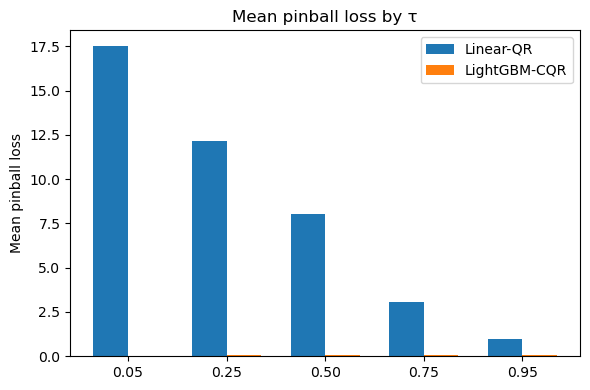

C:\Users\james\AppData\Local\Temp\ipykernel_31940\1241514455.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["y_true"] <= g["y_pred"]).mean())


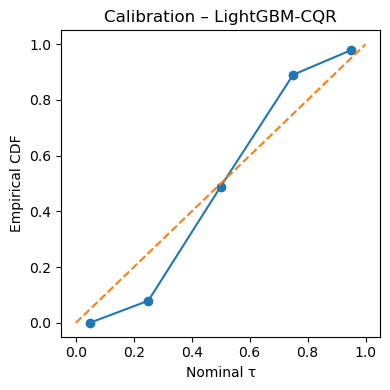

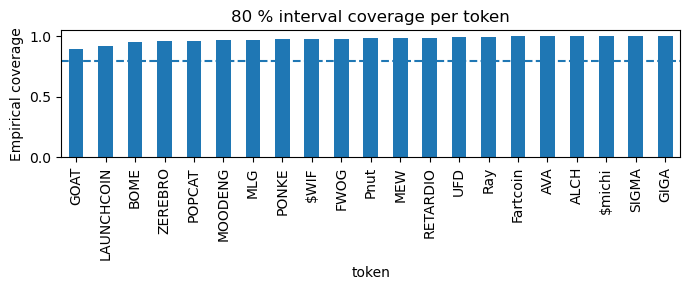

C:\Users\james\AppData\Local\Temp\ipykernel_31940\1241514455.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box, labels=["L-QR","LGBM-CQR"],


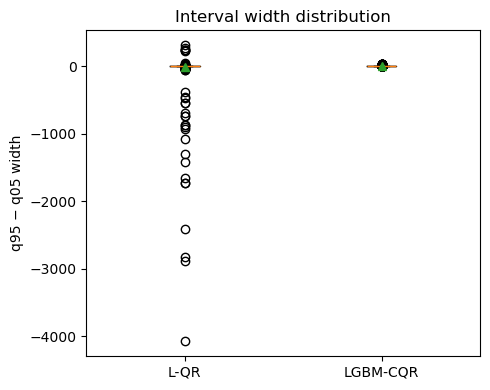

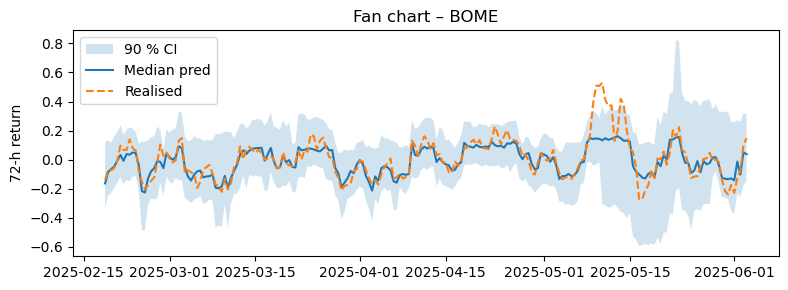

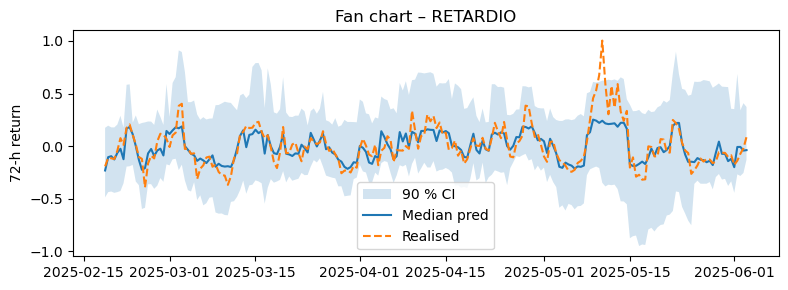

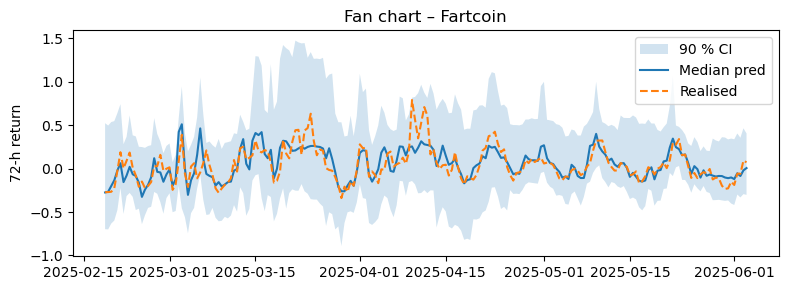

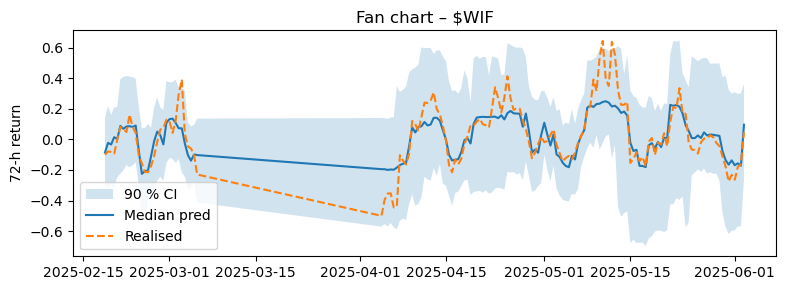

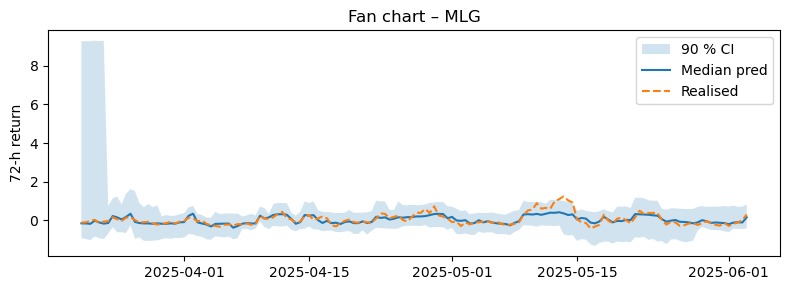

In [26]:
# ──────────────────────────────────────────────────────────────
# VISUAL SUITE – BASELINE COMPARISON & DIAGNOSTICS
#   1. Pinball-loss bar-chart  (L-QR vs. LightGBM-CQR)
#   2. Calibration curve       (LightGBM-CQR)
#   3. 80 % coverage line
#   4. Interval-width boxplot  (two models)
#   5. Fan charts (5 tokens)
# ──────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.style.use("default")      # keep colours automatic

# ————————————————————————————————————————————————————————
# 0. Load pinball-loss tables + per-row predictions
# ————————————————————————————————————————————————————————
pin_lin = pd.read_csv("stage7_linQR_pinball.csv")
pin_lgb = pd.read_csv("stage7_lgb_pinball.csv")

pred_lqr = pd.read_csv("stage7_linQR_preds.csv",
                       parse_dates=["timestamp"])
pred_lgb = pd.read_csv("stage7_lgb_preds.csv",
                       parse_dates=["timestamp"])

# ————————————————————————————————————————————————————————
# 1. Pinball-loss bar chart
# ————————————————————————————————————————————————————————
plt.figure(figsize=(6,4))
loss_lin = pin_lin.groupby("tau")["pinball"].mean()
loss_lgb = pin_lgb.groupby("tau")["pinball"].mean()
idx      = np.arange(len(loss_lin))

bar_w = 0.35
plt.bar(idx - bar_w/2, loss_lin.values,
        width=bar_w, label="Linear-QR")
plt.bar(idx + bar_w/2, loss_lgb.values,
        width=bar_w, label="LightGBM-CQR")

plt.xticks(idx, [f"{q:.2f}" for q in loss_lin.index])
plt.ylabel("Mean pinball loss")
plt.title("Mean pinball loss by τ")
plt.legend(); plt.tight_layout()
plt.show()

# ————————————————————————————————————————————————————————
# 2. Calibration curve (LightGBM-CQR only)
# ————————————————————————————————————————————————————————
cal = (pred_lgb
       .groupby("tau")
       .apply(lambda g: (g["y_true"] <= g["y_pred"]).mean())
       .sort_index())
plt.figure(figsize=(4,4))
plt.plot(cal.index, cal.values, marker="o")
plt.plot([0,1], [0,1], ls="--")
plt.xlabel("Nominal τ")
plt.ylabel("Empirical CDF")
plt.title("Calibration – LightGBM-CQR")
plt.tight_layout(); plt.show()

# ————————————————————————————————————————————————————————
# 3. Coverage of 80 % interval
# ————————————————————————————————————————————————————————
wide = (pred_lgb.query("tau==0.95")[["token","timestamp","y_pred"]]
         .rename(columns={"y_pred":"q95"})
         .merge(pred_lgb.query("tau==0.05")
                         .rename(columns={"y_pred":"q05"})
                         [["token","timestamp","q05"]],
                on=["token","timestamp"])
         .merge(pred_lgb.query("tau==0.50")
                         .rename(columns={"y_pred":"q50"})
                         [["token","timestamp","q50","y_true"]],
                on=["token","timestamp"]))

wide["covered"] = ((wide["y_true"] >= wide["q05"]) &
                   (wide["y_true"] <= wide["q95"]))

cov = (wide.groupby("token")["covered"].mean()
             .sort_values())

plt.figure(figsize=(7,3))
cov.plot(kind="bar")
plt.axhline(0.80, ls="--")
plt.ylabel("Empirical coverage")
plt.title("80 % interval coverage per token")
plt.tight_layout(); plt.show()

# ————————————————————————————————————————————————————————
# 4. Interval-width boxplot
# ————————————————————————————————————————————————————————
def width(df):
    q95 = df.query("tau==0.95")[["token","timestamp","y_pred"]]
    q05 = df.query("tau==0.05")[["token","timestamp","y_pred"]]
    w   = (q95.set_index(["token","timestamp"]) -
           q05.set_index(["token","timestamp"]))
    w.columns = ["width"]; return w["width"]

box = [width(pred_lqr).values,
       width(pred_lgb).values]

plt.figure(figsize=(5,4))
plt.boxplot(box, labels=["L-QR","LGBM-CQR"],
            showmeans=True)
plt.ylabel("q95 − q05 width")
plt.title("Interval width distribution")
plt.tight_layout(); plt.show()

# ————————————————————————————————————————————————————————
# 5. Fan charts – pick five longest-history tokens
# ————————————————————————————————————————————————————————
tok_long = (pred_lgb["token"]
            .value_counts()
            .nlargest(5).index)

for tok in tok_long:
    sub = pred_lgb[pred_lgb["token"]==tok]
    p05 = sub[sub["tau"]==0.05].set_index("timestamp")["y_pred"]
    p50 = sub[sub["tau"]==0.50].set_index("timestamp")["y_pred"]
    p95 = sub[sub["tau"]==0.95].set_index("timestamp")["y_pred"]
    yt  = sub[sub["tau"]==0.50].set_index("timestamp")["y_true"]

    plt.figure(figsize=(8,3))
    plt.fill_between(p05.index, p05, p95, alpha=0.2, label="90 % CI")
    plt.plot(p50.index, p50, label="Median pred")
    plt.plot(yt.index,  yt,  ls="--", label="Realised")
    plt.title(f"Fan chart – {tok}")
    plt.ylabel("72-h return")
    plt.legend(); plt.tight_layout(); plt.show()
